In [ ]:
### Monte Carlo Policy Control is a method to find the best policy for an agent to acheive a goal
### Maximizing its rewards in the process.

### It works taking the best action for a state, exactly similar to what we did in the case of policy iteration
### Or policy improvement method, using the state-action value or Q function. 

### Its just that, it is applied on Model Free environment, so we use the Monte Carlo method, to sample random walks
### or trails from the environment, and gather experience from it. The updation of the Q function (from where we sample the policy using argmax)
### is done using Monte Carlo Online Policy as we did for the Value function in the evaluation part

### Q[s,a]=Q[s,a]+((1/N[s,a])*(G - Q[s,a]))

### Just that in this case, we need to find the expected reward for a particular action on a particular state.

### BELLMAN EQUATION WAS USED IN MODEL BASED FOR ESTIMATION, IN MODEL FREE THE Q[S,A] updation changes.

### In case of Monte Carlo policy control, we need to sample the action also from the ground walks, as we want to find the maximum value based on the 
### actions for a particular state.

### Policy is again found using, the argmax(Q) on the actions axis, for all the states. 
### Dimension of Q= S x A. 
"""
[
 [50,60,30],   ### 50 is the Q value for state 0 under action 0 
 [40,25,70]    ### 25 will be Q value of state 1 under action 1 and 40 is the Q value of state 1 under action 0.
 [60,35,20]

]

Each row depicts the Q value for all actions in that state

Dimension of the Q matrix: 3 x 3: so 3 states, 3 states. Now if we take argmax on action axis or 1 axis:
[1,2,0] as the actions, as 60 is the largest Q value for state 0 and it comes from action 1 in the centre.

[1,2,0] is the developed policy.

#### THE DIMENSION IS DIFFERENT FROM MDP, SO ACTION CHANGES ####
"""


####### EXPLORATION VS EXPLOITATION ########

### For finding the best policy, the agent must explore the environment very well, so it has to take some random actions at some states, in order to
### Check how the environment reacts, and also try a new avenue to check if the return is more.

### But, if the agent keeps on exploring all through out the training phase, it will never be able to find the best policy. So, after some exploring,
### The agent must exploit or use the insights it has already gained to find the best policy.

### So, exploration is necessary, but so is exploitation, and there stands a tradeoff.

### To get the best policy, we must first explore and then reduce the exploration and start exploiting as by then our agent will have enough information
### about the environment to device a good policy.

### To implement this we use a exploration rate parameter, that linearly decays rull a certain number of episodes and the become constant at a very small 
### Value, so that the exploration decreases over time and more epiisodes, but does not fully stop. 

### So, exploration rate: epsilon= 

### 1. Steady epsilon: if current episode > threshold episode
### 2. Slope*episode + 1 if current episode <= threshold episode

### where, Slope= (Steady epsilon - 1)/(threshold episode - 0)  ### Slope of the linear decay

### So, the initial value of epsilon is 1 at episode 0, so, that point is (1,0) as the starting point of the line.
### and the value of epsilon should be equal to Steady epsilon at the threshold episode so, point is (Steady epsilon, thresold episode)
### which serves as the last point of the line. Thus the slope is calculated.

### Now, the best action according to the policy is taken with a probability of (1-epsilon) for an episode, and any random action in the whole action space
### can be taken with the probability epsilon for an episode.

### So, for each action other than the best can be selected with probability (epsilon/|A|). where A is the entire action space.
### and the best can be chosen with ((1-epsilon)+ (epsilon/|A|)). 



In [ ]:
## In case of constantly changing environment, we cannot decrease the exploration rate, as the behaviour of the world
### always changes, and the agent must be able to keep up in modifying the policy.
 

### Accessing Environment 

In [1]:
!pip3 install pygame

     |████████████████████████████████| 11.8MB 481kB/s 


In [2]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

pygame 2.0.1 (SDL 2.0.14, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(640x480x32 SW)>

In [ ]:
!unzip images.zip

In [ ]:
!unzip modules.zip

In [5]:
from gridworld import GridWorld
import numpy as np

In [6]:
world=\
    """
    wwwwwwwwww
    wa       w
    w    wwwww
    wwww     w
    w        w
    w        w
    w        w
    w g  wwwww
    w        w
    wwwwwwwwww
    """

#### World Declaration
env=GridWorld(world)

env._max_epi_step=200     ## Number of maximum steps in an episode

In [7]:
import matplotlib.pyplot as plt
import cv2

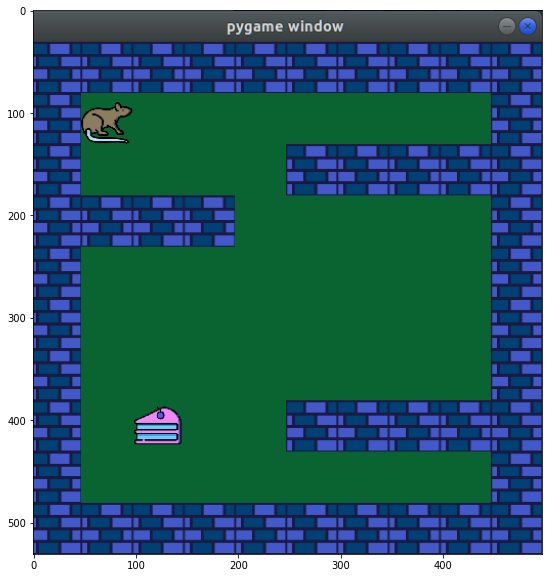

In [8]:
img=cv2.imread("problem_window.png")
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

### Monte Carlo Policy Control

In [11]:
import numpy as np
import tqdm

In [9]:
def generate_episodes(policy):   ### Generating ground trail based experience

  episodes=[]
  curr_state=env.reset()  ### Returns a starting state.
  done=False ### Signifies if the episode is over.

  while not done:
    action=policy[curr_state]  ## Choosing the action for the state according to the policy.
    next_state,reward,done,_=env.step(action)  ### Returns from environment on taking an action
    episodes.append((curr_state,action,reward))  ### keeping record of the path in an episode (state,action,reward)
    curr_state=next_state ### updating state

  return episodes

In [10]:
def get_rewards(episode,gamma=0.99):  ## Obtaining G for a particular action on a particular state

  Gt=[] ### Returns for time steps

  for i,(s,a,r) in enumerate(episode):
    sum_t=r #### sum starts with current reward + discounted sum of future rewards
    future=episode[i+1:]  ### Future starts from the next timestep from the current one
    for j,(s_f,a_f,r_f) in enumerate(future):  
      ### Iterating on future states and rewards
      sum_t+=(gamma)**(j+1)*r_f  ### Adding discounted sum of rewards for the future steps
    Gt.append((s,a,sum_t))  ### We maintain (state, action, discounted sum of rewards)
  
  return Gt
  

In [13]:
def get_e(episode,steady_epsilon=0.01,steady_episode=1000):
  ### Obtaining the epsilon for the episode.
  ### The steady epsilon, we settle on is 0.01 after episode 1000
  ### Till 1000, epsilon decays linearly.

  if episode>steady_episode:  ##If we are above the steady episode, we return a steady epsilon
    return steady_epsilon
  else:
    slope=(steady_epsilon - 1)/(steady_episode - 0) 
    ### Line (1,0) to (steady_epsilon,steady_episode)

    ### slope*episode will give us the decrease in the value of epsilon
    ### To get the value we add 1 to the value so it is (1 - decrease), as epsilon starts from 1.
    return slope*episode + 1


In [23]:
def obtain_policy_greed(Q_function, epsilon, actions):
  ### Obtaining policy based on the current Q function values, and epsilon value.
  ### This method is called E-greedy policy.

  policy=[]  ### Initializing the policy
  optimal_policy=np.argmax(Q_function,axis=1)  ### S x A dimension: so, action on axis=1

  for s in range(Q_function.shape[0]):
    ### Shape[0]: represents the number of states: SxA.

    if np.random.random()<=1-epsilon:  ### Random.random() generates number in (0,1) 
    ###probability 1/(b-a). where b and a are upper and lower limits
      chosen_action=optimal_policy[s]
      #### Choosing the best action according to policy. with probability (1-epsilon)
    else:
      chosen_action=np.random.choice(actions)
      ### else choosing random action with probability epsilon/|actions| for each.

    policy.append(chosen_action) ## Appending chosen action to the policy to return.
  
  return policy

In [28]:
def get_policy():
  Q=np.zeros((env.state_count,len(env.action_space)))
  N=np.zeros((env.state_count,len(env.action_space)))

  ### initializing the Q function and N to record the details of the actions on a particular state.
  epsilon=1 ## Initially exploration control value 1: maximum
  policy=obtain_policy_greed(Q,epsilon,env.action_space) ### Finding the initial policy. Totally random

  for episode_number in tqdm.tqdm(range(50000)):  
    ### We train on a batch of 50000 collected episodes.
    episode=generate_episodes(policy) ### Generating the episode
    epi_with_return=get_rewards(episode) ### Generates in the form (s,a,G) for each state in the episode
    for s,a,G in epi_with_return:
      N[s,a]+=1
      Q[s,a]=Q[s,a]+(1/N[s,a])*(G-Q[s,a])
      #### Updating the Q function on every state we see in that particular episode using monte carlo online policy
    epsilon=get_e(episode_number) ### Getting the epsilon for the episode.
    policy=obtain_policy_greed(Q,epsilon,env.action_space)
    ### Updating the policy after each episode.
  return policy

In [29]:
policy=get_policy()

100%|██████████| 50000/50000 [11:50<00:00, 70.38it/s]


In [32]:
print(policy)

[3, 2, 2, 3, 0, 3, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 2, 1, 3, 1, 1, 3, 1, 3, 0, 2, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 3, 2, 2, 3, 2, 3, 2]


In [33]:
env.setPolicy(policy)

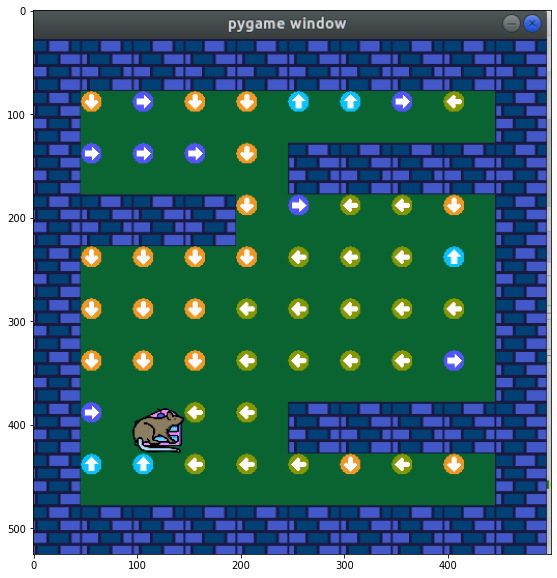

In [34]:
img=cv2.imread("route_mc.png")
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In [35]:
### The problem with monte carlo:

### 1. The policy update is slow as the policy is updated only once, after each episode.

### 2. The method works on real data. So, it is a high variance method. 

### Monte-carlo needs episodic setting.

### The exploration decay is put forward by a theory called GLIE: Greedy in the Limit of Infinite 
### Exploration.

### It proves: if the exploration coeffiecient decays proportional to (1/t) where t is episode number.
### and 1/N[s,a] approaches infinity: the policy converges to a greedy policy. 
